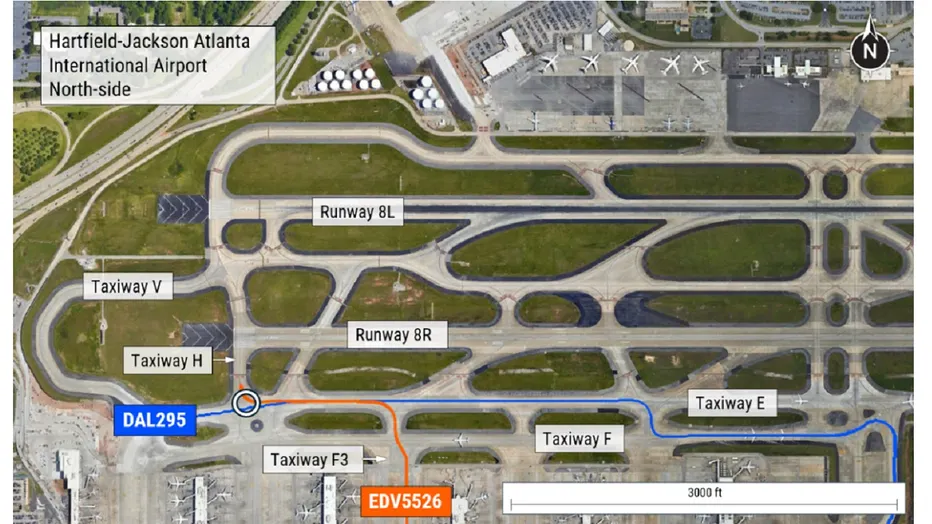

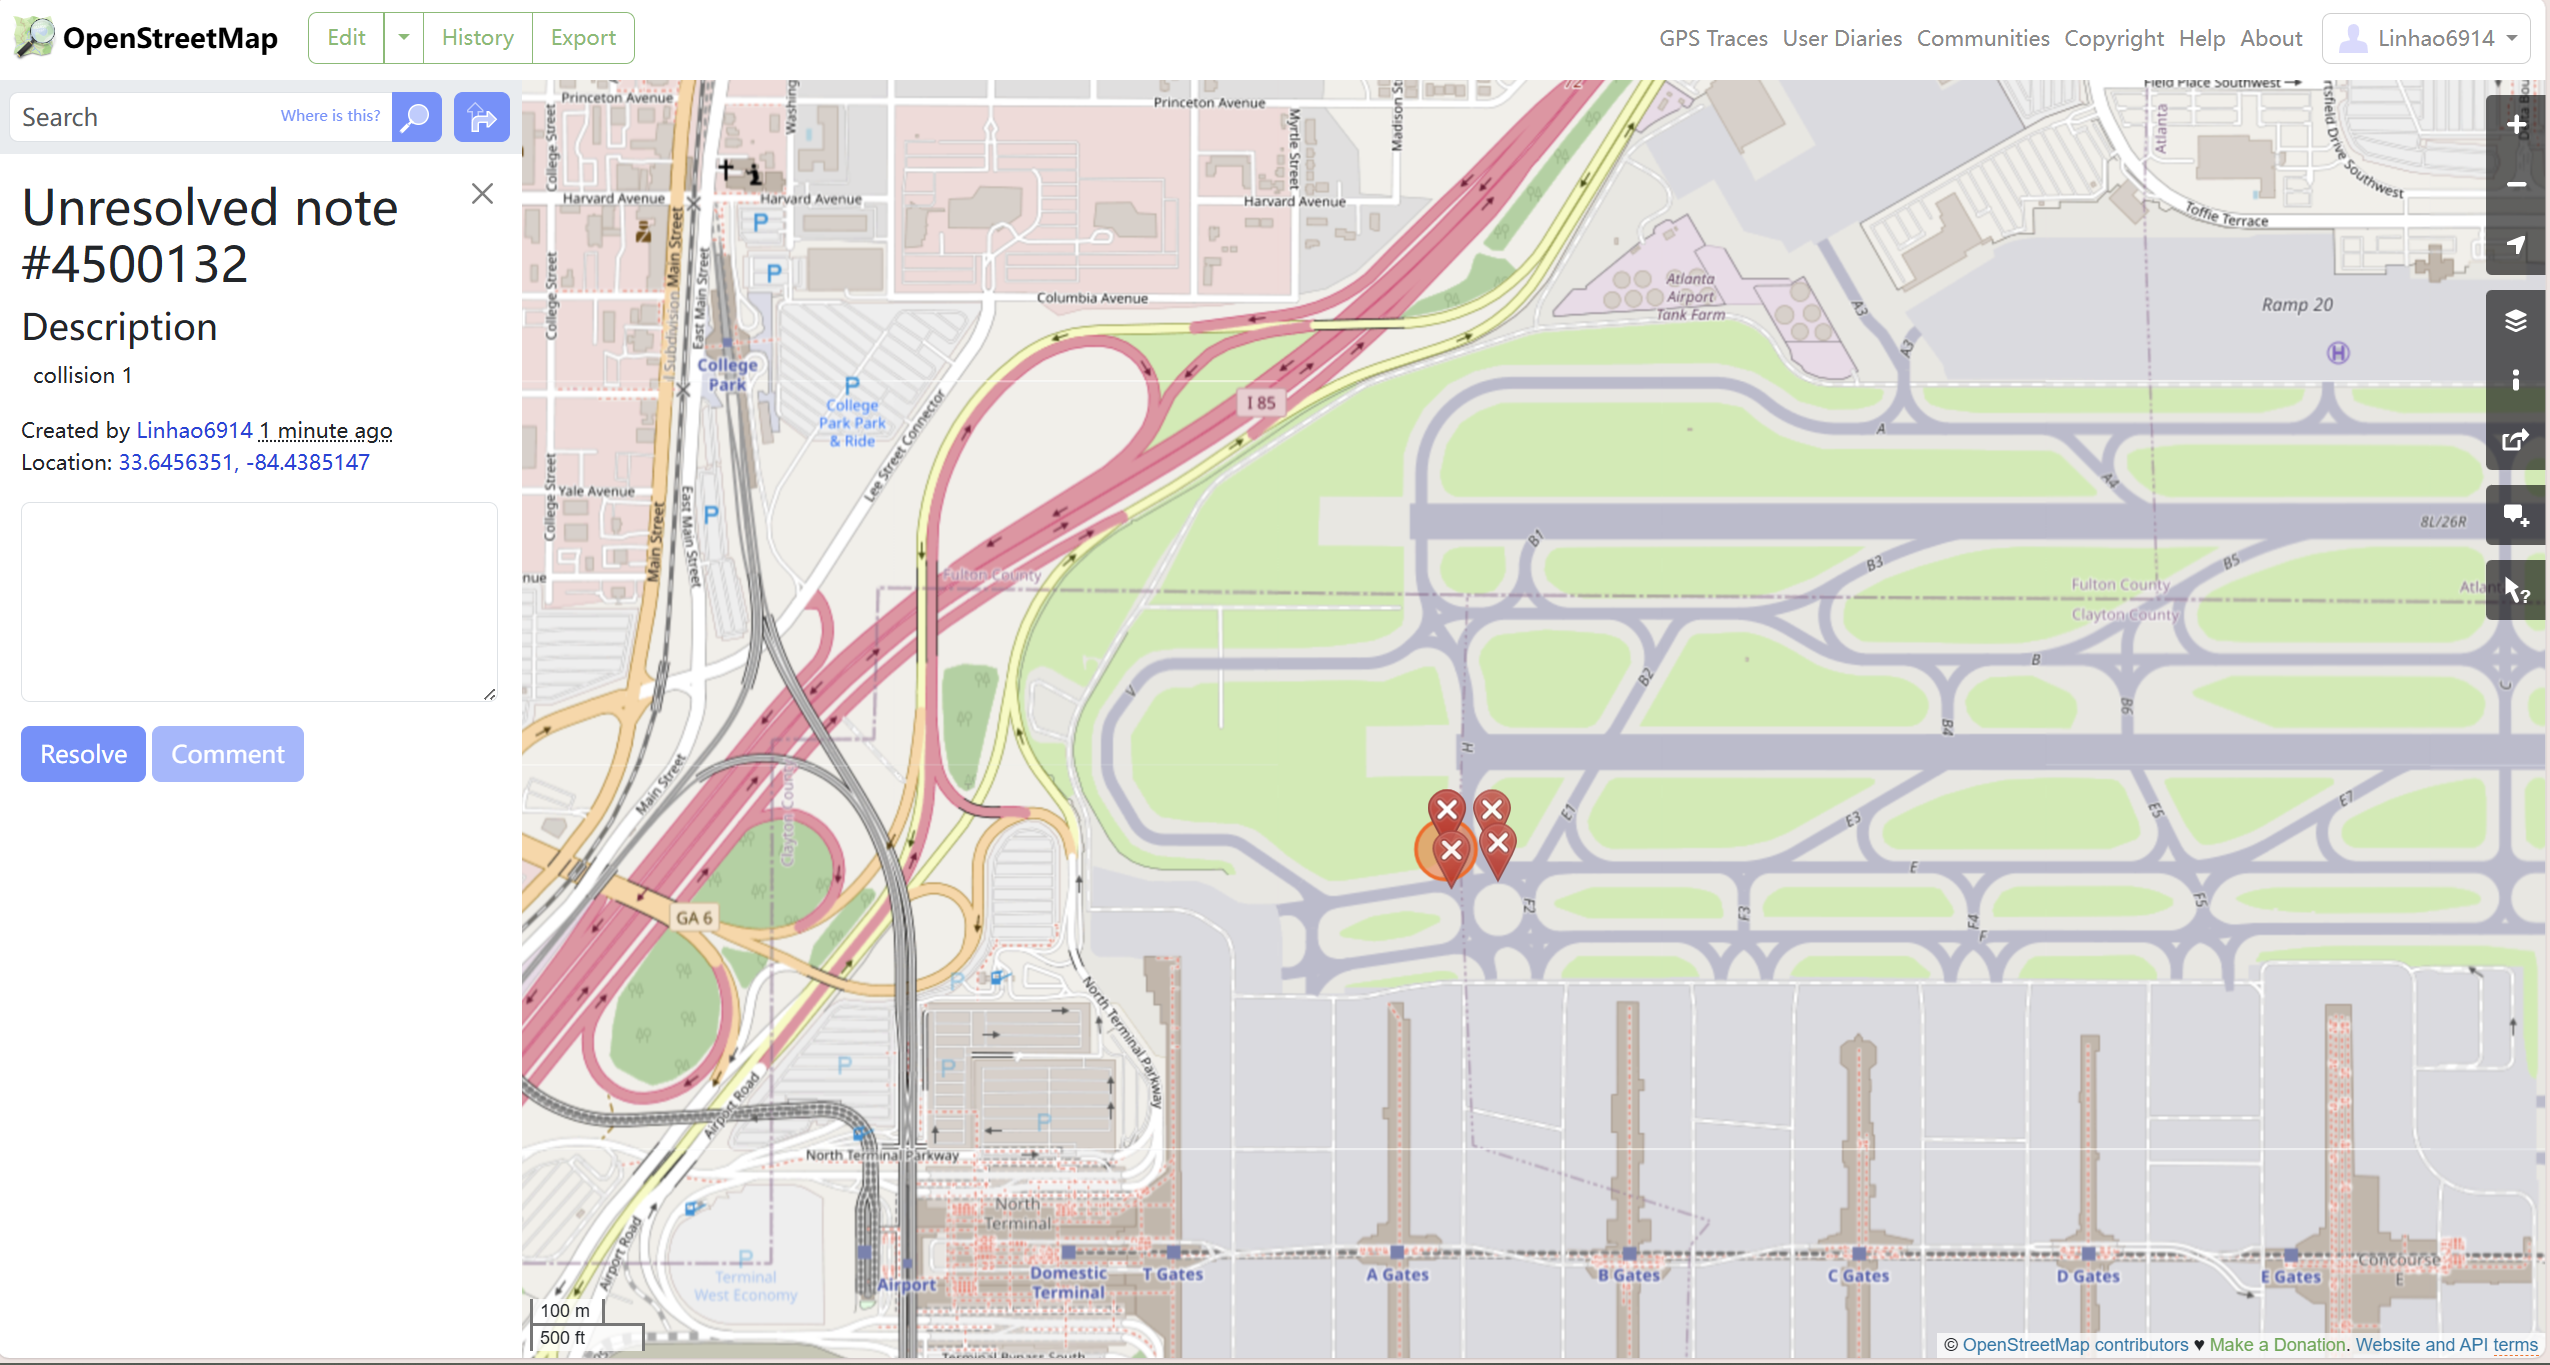

latitude:(33.6456351,33.6451600)
longitude:(-84.4385147,-84.4378700)

# PART 1: Prepocess

In [5]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from geopy.distance import geodesic  # calculate distance
import warnings
warnings.filterwarnings("ignore")

In [7]:
file_path = '153 datasets/IFF_ATL+ASDEX_20190727_050128_85866.csv'
data = pd.read_csv(file_path, header=None, skiprows=20, on_bad_lines='skip')
print(data.head())

   0             1      2      3   4          5      6       7   8         9   \
0   3  1.564203e+09  29433  702.0 NaN  ATL+ASDEX  0xE02  BOX420   1  33.73995   
1   3  1.564203e+09  29433  702.0 NaN  ATL+ASDEX  0xE02  BOX420   1  33.73937   
2   3  1.564203e+09  29433  702.0 NaN  ATL+ASDEX  0xE02  BOX420   1  33.73879   
3   3  1.564203e+09  29433  702.0 NaN  ATL+ASDEX  0xE02  BOX420   1  33.73830   
4   3  1.564203e+09  29433  702.0 NaN  ATL+ASDEX  0xE02  BOX420   1  33.73774   

   ...   35   36     37  38   39  40   41   42   43  44  
0  ...  NaN  ATL  359.0 NaN  NaN NaN  NaN  NaN  NaN NaN  
1  ...  NaN  ATL  359.0 NaN  NaN NaN  NaN  NaN  NaN NaN  
2  ...  NaN  ATL  359.0 NaN  NaN NaN  NaN  NaN  NaN NaN  
3  ...  NaN  ATL  359.0 NaN  NaN NaN  NaN  NaN  NaN NaN  
4  ...  NaN  ATL  359.0 NaN  NaN NaN  NaN  NaN  NaN NaN  

[5 rows x 45 columns]


In [9]:
# clean up, select data which have geodata 
data_cleaned = data[data[9].astype(str).str.len() == 8]

grouped_data_cleaned = data_cleaned.groupby(2) 
print(f"number of trajectories: {len(grouped_data_cleaned)}")

print(grouped_data_cleaned[2].head())

number of trajectories: 121
0        29433
1        29433
2        29433
3        29433
4        29433
         ...  
64878    29598
64879    29598
64880    29598
64881    29598
64882    29598
Name: 2, Length: 605, dtype: int64


In [11]:
# 定义 haversine 函数，用于计算两点之间的距离（单位：米）
def haversine(lat1, lon1, lat2, lon2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # 地球半径（米）
    R = 6371000
    
    # 计算差值
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # 计算haversine公式
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [13]:
# 创建空列表存储速度
speeds = []

# 遍历每个轨迹
for _, group in data_cleaned.groupby(2):  # 2表示 trajectory ID 列的下标
    group = group.sort_values(by=1)  # 1 表示时间戳列的下标
    
    # 将纬度和经度转换为numpy数组
    latitudes = group[9].values
    longitudes = group[10].values
    timestamps = group[1].values
    # 将 latitudes 和 longitudes 列转换为浮点数类型
    latitudes = latitudes.astype(float)
    longitudes = longitudes.astype(float)

    # 计算速度
    group_speeds = [0]  # 第一个点速度为 0
    for i in range(1, len(group)):
        # 计算时间差（秒）
        time_diff = timestamps[i] - timestamps[i - 1]
        
        # 计算距离（假设以米计算）
        distance = haversine(latitudes[i-1], longitudes[i-1], latitudes[i], longitudes[i])
        
        # 计算速度（m/s），避免除以零
        speed = distance / time_diff if time_diff != 0 else 0
        group_speeds.append(speed)
    
    # 将此组速度添加到总速度列表
    speeds.extend(group_speeds)

# 将速度列添加到数据集中
data_cleaned['speed'] = speeds

In [15]:
print(data_cleaned['speed'])

0          0.000000
1        152.960493
2        152.961344
3        146.440781
4        152.038619
            ...    
65530      3.461910
65531      3.461910
65532      2.408872
65533      1.204436
65534      0.602218
Name: speed, Length: 64419, dtype: float64


In [22]:
# eg
trajectory_id_eg = 29598  # eg ID
trajectory_data = data_cleaned[data_cleaned[2] == trajectory_id_eg]  
print(trajectory_data)

# geo
longitude = trajectory_data[10].astype(float)  # 第10列为经度longitude
latitude = trajectory_data[9].astype(float)    # 第9列为纬度latitude
timestamp = trajectory_data[1].astype(float)   # 时间戳timestamp

       0             1      2       3   4          5      6       7  8  \
64878  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64879  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64880  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64881  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64882  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
...   ..           ...    ...     ...  ..        ...    ...     ... ..   
65530  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65531  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65532  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65533  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65534  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   

              9  ...   36     37  38      39  40   41   42   43  44  \
64878  33.73444  ...  ATL  330.0 NaN    

# PART 2 Visualization

In [26]:
# eg
trajectory_id_eg = 29598  # eg ID
trajectory_data = data_cleaned[data_cleaned[2] == trajectory_id_eg]  
print(data_cleaned[data_cleaned[2] == trajectory_id_eg])

# geo
longitude = trajectory_data[10].astype(float)  # 第10列为经度longitude
latitude = trajectory_data[9].astype(float)   # 第9列为纬度latitude

# create map
m = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=14, tiles='Stamen Terrain')

# layer of satellites
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('CartoDB positron').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)

# visualize
folium.PolyLine(locations=list(zip(latitude, longitude)), color='red', weight=2.5, opacity=0.8).add_to(m)

# display
# m

       0             1      2       3   4          5      6       7  8  \
64878  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64879  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64880  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64881  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
64882  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
...   ..           ...    ...     ...  ..        ...    ...     ... ..   
65530  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65531  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65532  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65533  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   
65534  3  1.564225e+09  29598  5220.0 NaN  ATL+ASDEX  0xE02  DAL823  1   

              9  ...   36     37  38      39  40   41   42   43  44  \
64878  33.73444  ...  ATL  330.0 NaN    

In [28]:
import pandas as pd

# 转换纬度和经度列为浮点数类型
data_cleaned.iloc[:, 9] = pd.to_numeric(data_cleaned.iloc[:, 9], errors='coerce')
data_cleaned.iloc[:, 10] = pd.to_numeric(data_cleaned.iloc[:, 10], errors='coerce')

# 定义经纬度范围
lat_min, lat_max = 33.6451600, 33.6456351
lon_min, lon_max = -84.4385147, -84.4378700

# 筛选出在指定范围内的轨迹点
in_range_points = data_cleaned[
    (data_cleaned.iloc[:, 9] >= lat_min) & (data_cleaned.iloc[:, 9] <= lat_max) &
    (data_cleaned.iloc[:, 10] >= lon_min) & (data_cleaned.iloc[:, 10] <= lon_max)
]

# 获取满足条件的trajectory ID
valid_trajectory_ids = in_range_points.iloc[:, 2].unique()  # 假设trajectory ID在第3列

# depending on trajectory ID to filter whole trajectory
filtered_trajectories = data_cleaned[data_cleaned.iloc[:, 2].isin(valid_trajectory_ids)]

print(filtered_trajectories[2].unique())

[29443 29457 29497 29511 29513 29522 29523 29524 29526 29527 29530 29537
 29538 29540 29543 29551 29554 29560 29562 29563 29564 29578 29587 29592
 29593]


In [30]:
# 可视化轨迹并根据速度改变颜色
# [638145 638146 638169 638171 638189 638196 638202 638206 638212 638217
# 638222 638278 638394 638410 638471 638489 638798 638861 638872 638877
# 638899 638987]

# 创建地图
m = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=14, tiles='Stamen Terrain')

# 增加地图层
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('CartoDB positron').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)

# eg 2
trajectory_id_eg = 29543 # eg ID

trajectory_data = data_cleaned[data_cleaned[2] == trajectory_id_eg]  
print(trajectory_data)

# geo
longitude = trajectory_data[10].astype(float)  # 第10列为经度longitude
latitude = trajectory_data[9].astype(float)    # 第9列为纬度latitude
timestamp = trajectory_data[1].astype(float)   # 时间戳timestamp

for i in range(1, len(latitude)):
    coord1 = (latitude.iloc[i-1], longitude.iloc[i-1])
    coord2 = (latitude.iloc[i], longitude.iloc[i])

    # color up to speed ## rough ### threshold can vary by the type of aircraft
    if speeds[i] > 90: 
        color = 'red'  # fast
    elif speeds[i] > 15:
        color = 'orange'  # medium
    else:
        color = 'blue'  # low
    # draw
    folium.PolyLine(locations=[coord1, coord2], color=color, weight=3, opacity=0.8).add_to(m)
# display
m

       0             1      2       3   4          5      6        7  8  \
49454  3  1.564222e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49455  3  1.564222e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49456  3  1.564222e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49457  3  1.564222e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49458  3  1.564222e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
...   ..           ...    ...     ...  ..        ...    ...      ... ..   
49926  3  1.564223e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49927  3  1.564223e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49928  3  1.564223e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49929  3  1.564223e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   
49930  3  1.564223e+09  29543  2513.0 NaN  ATL+ASDEX  0xE02  FFT1510  1   

              9  ...   36      37  38      39  40   41   42   43  44  \
49454   33.6434  ...  JAC  